<a href="https://colab.research.google.com/github/afoster145/iphs290_cultural_analytics_lda_topic_modeling/blob/main/Copy_of_sa_gutenberg_class_20211101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jon Chun
24 Oct 2021

# **Requirements**

* Must use **Chrome** browser (esp not Safari)
* Use only **plain text** files (no *.rtf, *.doc, etc)

# **Setup and Configuration**

In [ ]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 14.2 MB/s 
     |████████████████████████████████| 53 kB 1.0 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=97287fad0cb28df8a0b27f2283198fe809775f60af3f3f890384c0bd9af2c3fe
  Stored in directory: /root/.cache/pip/wheels/5e/8c/80/c3646df8201ba6f5070297fe3779a4b70265d0bfd961c15302
Successfully built emoji


In [ ]:
!pip install unidecode  # clean-text dependency

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 9.9 MB/s 


In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 31.0 MB/s 
     |████████████████████████████████| 110 kB 60.5 MB/s 


In [ ]:
!pip install python-slugify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Python Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

from cleantext import clean
import contractions
from slugify import slugify

from scipy.signal import find_peaks

from google.colab import files



In [ ]:
# Setup matplotlib

# %matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Globals

In [ ]:
# Global Vars

novel_filename_str = ''
novel_title_str = ''
novel_raw_str = ''
novel_clean_str = ''

novel_lines_ls = []
novel_sentences_ls = []
novel_paragraphs_ls = []

# Main (Modin) DataFrame for Novel Sentiments
sentiment_df = pd.DataFrame

TEXT_ENCODING = 'utf-8'

In [ ]:
def verify_novel(anovel_raw_str, anovel_title_str, index_ends=500):
  '''
  INPUT: string in some stage of processing
  OUTPUT: display summary index_ends chars of header/footer for verification
  '''

  print(f'Novel Title: {anovel_title_str}')
  print(f'  Char Len: {len(anovel_raw_str)}')
  print('====================================\n')
  print(f'Beginning:\n\n {anovel_raw_str[:index_ends]}\n\n')
  print('\n------------------------------------')
  print(f'Ending:\n\n {anovel_raw_str[-index_ends:]}\n\n')

In [ ]:
def save_text2txt_and_download(text_obj, file_suffix='_save.txt'):
  '''
  INPUT: text object and suffix to add to output text filename
  OUTPUT: Write text object to text file (both temp VM and download)
  '''

  if type(text_obj) == str:
    print('STEP 1. Processing String Object\n')
    str_obj = text_obj
  elif type(text_obj) == list:
    if (len(text_obj) > 0):
      if type(text_obj[0]) == str:
        print('STEP 1. Processing List of Strings Object\n')
        str_obj = "\n".join(text_obj)
      else:
        print('ERROR: Object is not an List of Strings [save_text2txt_and_download()]')
        return -1
    else:
      print('ERROR: Object is an empty List [save_text2txt_and_download()]')
      return -1
  else:
    print('ERROR: Object Type is neither String nor List [save_text2txt_and_download()]')
    return -1

  datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  # out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
  out_filename = novel_name_str.split('.')[0] + file_suffix

  # Write file to temporary VM filesystem
  print(f'STEP 2. Saving textfile to temporary VM file: {out_filename}\n')
  with open(out_filename, "w") as fp:
    fp.write(str_obj)

  # Download permanent copy of file
  print(f'STEP 3. Downloading permanent copy of textfile: {out_filename}\n')
  files.download(out_filename)

In [ ]:
def save_df2csv_and_download(df_obj, file_suffix='_save.csv', nodate=True):
  '''
  INPUT: DataFrame object and suffix to add to output csv filename
  OUTPUT: Write DataFrame object to csv file (both temp VM and download)
  '''

  if isinstance(df_obj, pd.DataFrame):
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
      out_filename = novel_name_str.split('.')[0] + file_suffix
    else:
      out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
    # print(f'STEP 1. Saving DataFrame: {df_obj.__name__} to temporary VM file: {out_filename}\n') # Also, isinstance(obj, pd.DataFrame)
    print(f'STEP 1. Saving DataFrame to temporary VM file: {out_filename}\n')
    df_obj.to_csv(out_filename, index=False) 
  else:
    print(f'ERROR: Object is not a DataFrame [save_df2csv_and_download()]')
    return -1

  # Download permanent copy of file
  print(f'STEP 2. Downloading permanent copy of csvfile: {out_filename}\n')
  files.download(out_filename)


# Test

# save_df2csv_and_download(temp_df, '_bert-nlptown.txt')

In [ ]:
def expand_contractions(input_str):
  '''
  INPUT: long string
  OUTPUT: long string with expanded contractions
  '''

  output_str = contractions.fix(input_str)

  return output_str

"""
# novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_ls]
novel_clean_ls = [contractions.fix(x) for x in novel_ls]
novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_clean_ls]
novel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]
# novel_clean_ls = [re.sub(r"^[\"\']", "", x) for x in novel_clean_ls]  # re.sub("[\"\']", "", s)
# novel_clean_ls = [re.sub(r"[\"\']$", "", x) for x in novel_clean_ls]
novel_clean_ls = [x.encode('ascii',errors='ignore').decode() for x in novel_clean_ls]
# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

[f'[{x}]' for x in novel_clean_ls]
"""

'\n# novel_clean_ls = [re.sub(r\'[\n]+\', \' \', x).strip() for x in novel_ls]\nnovel_clean_ls = [contractions.fix(x) for x in novel_ls]\nnovel_clean_ls = [re.sub(r\'[\n]+\', \' \', x).strip() for x in novel_clean_ls]\nnovel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]\n# novel_clean_ls = [re.sub(r"^["\']", "", x) for x in novel_clean_ls]  # re.sub("["\']", "", s)\n# novel_clean_ls = [re.sub(r"["\']$", "", x) for x in novel_clean_ls]\nnovel_clean_ls = [x.encode(\'ascii\',errors=\'ignore\').decode() for x in novel_clean_ls]\n# novel_bin = novel_clean_str.encode(\'ascii\',errors=\'ignore\')\n# novel_clean_str = novel_bin.decode()\n\n[f\'[{x}]\' for x in novel_clean_ls]\n'

# **Get the Novel Text**

## OPTION (a): Upload Raw Textfile

In [ ]:
%%time

# NOTE: 1m07s

# Upload Plain Text File
uploaded = files.upload('LittleWomen.txt')

# NOTE: Allows for multiple file uploads, will only process the last
#       Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  novel_filename_str = fn

# Extract from Dict and decode binary into char string
novel_raw_str = uploaded[novel_filename_str].decode(TEXT_ENCODING)

NameError: ignored

In [ ]:
#@title Enter Novel_Title in the form [Title] by [Author]

Novel_Title = "Little Women by Louisa May Alcott" #@param {type:"string"}

# Remove illegal filename punctuation
Novel_Title = Novel_Title.replace("'","")
Novel_Title = Novel_Title.replace('"','')
Novel_Title = Novel_Title.replace('.',' ')

novel_title_str = ' '.join([x.capitalize() for x in slugify(Novel_Title).replace('-',' ').split()])
novel_title_str

'Bartlebly By Herman Melville'

In [ ]:
# CHECK: That you've trimmed the header/footer before uploading

print(f'Novel Filename:\n\n  {novel_filename_str}\n\n')

verify_novel(novel_raw_str, novel_title_str)

Novel Filename:

  


Novel Title: 
  Char Len: 0

Beginning:

 



------------------------------------
Ending:

 




## OPTION (b): Read from gDrive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive

MessageError: ignored

In [ ]:
# drive.mount("/gdrive", force_remount=True)

In [ ]:
# CUSTOMIZE: set GDrive path below

%cd ./MyDrive/courses/2021f_iphs200_programming_humanity/code/

In [ ]:
!ls *.txt

In [ ]:
# CUSOTMIZE: set 'novel_filename' to the filename of your novel

# novel_filename = 'jkrowling_1sorcerersstone.txt'
novel_filename_str ='Percy_Jackson_The_Lightning_Thief.txt'

In [ ]:
#@title Enter Novel_Title in the form [Title] by [Author]

Novel_Title = "The Lightening Thief by Percy Jackson" #@param {type:"string"}
novel_title_str = Novel_Title

In [ ]:
# Read file into string

with open(novel_filename_str, "r") as fp:
  novel_raw_str = fp.read() #reading all the content in one step

In [ ]:
# Verify

# CHECK: That you've trimmed the header/footer before uploading

print(f'Novel Filename:\n\n  {novel_filename_str}\n\n')

verify_novel(novel_raw_str, novel_title_str)

In [ ]:
# END

In [ ]:
# Read novel into list of Paragraphs

delimiter = "\n\n"

with open(novel_filename, "r") as fp:
  novel_raw_str = fp.read() #reading all the content in one step
  #using the string methods we split it
  novel_parags_ls = novel_raw_str.split(delimiter)
  novel_parags_ls = [x.strip() for x in novel_parags_ls if len(x.strip()) > 2]

print(f'Paragraph Count: {len(novel_parags_ls)}')

In [ ]:
# Read novel into list of Lines

# may need delimiter

with open(novel_filename, 'r') as fp:
  novel_lines_ls = fp.readlines()

print(f'Line Count: {len(novel_lines_ls)}')

In [ ]:
novel_parags_ls[:10]

In [ ]:
novel_ls[100:110]

In [ ]:
# novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_ls]
novel_clean_ls = [contractions.fix(x) for x in novel_ls]
novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_clean_ls]
novel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]
# novel_clean_ls = [re.sub(r"^[\"\']", "", x) for x in novel_clean_ls]  # re.sub("[\"\']", "", s)
# novel_clean_ls = [re.sub(r"[\"\']$", "", x) for x in novel_clean_ls]
novel_clean_ls = [x.encode('ascii',errors='ignore').decode() for x in novel_clean_ls]
# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

[f'[{x}]' for x in novel_clean_ls]

In [ ]:
novel_clean_str = '\n'.join(novel_clean_ls)
print(novel_clean_str[:5000])

In [ ]:
# novel_clean_ls[1] = "THE SILVER SPOON I was born twice: first, as a baby girl, on a remarkably smogless Detroit day in January of 1960; and then again, as a teenage boy, in an emergency room near Petoskey, Michigan, in August of 1974. Specialized readers may have come across me in Dr. Peter Luce’s study, “Gender Identity in 5-Alpha-Reductase Pseudohermaphrodites,” published in theJournal of Pediatric Endocrinology in 1975. Or maybe you’ve seen my photograph in chapter sixteen of the now sadly outdatedGenetics and Heredity."

In [ ]:
# novel_clean_ls.pop(0)

In [ ]:
novel_clean_ls[:10]

In [ ]:
novel_clean_ls[-10:]

In [ ]:
# novel_clean_str = '\n'.join(novel_clean_ls)

# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

# print(novel_clean_str[:5000])

## OPTION (c): Scrape Project Gutenberg

**Goto *https://gutenberg.net.au* and find the *.HTML (not *.TXT) version of your novel**

In [ ]:
from bs4 import BeautifulSoup

import requests

In [ ]:
#@title Enter the URL of your novel at ***gutenberg.net.au***
#@markdown Paste the URL to the ***HTML version*** (not plain text).

Novel_Title = 'The Great Gatsby by F Scott Fitzgerald'  #@param {type: "string"}

Gutenberg_URL = 'https://gutenberg.net.au/ebooks02/0200041h.html'  #@param {type: "string"}


In [ ]:
# Get raw HTML of novel from Gutenberg.net.au

response=requests.get(Gutenberg_URL)  # TODO: Pass the URL to the .get() method of the requests object
html = response.text

In [ ]:
# View raw HTML that we need to clean up

# TODO: What is the difference between these two outputs?

# Option A: 
html

# Option B:
# print(html)

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">\n<html>\n<head>\n<meta name="generator" content="HTML-Kit Tools HTML Tidy plugin">\n<!-- Google tag (gtag.js) -->\n<script async src="https://www.googletagmanager.com/gtag/js?id=G-ND4S2CL5PN"></script>\n<script>\n  window.dataLayer = window.dataLayer || [];\n  function gtag(){dataLayer.push(arguments);}\n  gtag(\'js\', new Date());\n\n  gtag(\'config\', \'G-ND4S2CL5PN\');\n</script>\n\n<!-- Google Tag Manager -->\n<script>(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({\'gtm.start\':\nnew Date().getTime(),event:\'gtm.js\'});var f=d.getElementsByTagName(s)[0],\nj=d.createElement(s),dl=l!=\'dataLayer\'?\'&l=\'+l:\'\';j.async=true;j.src=\n\'https://www.googletagmanager.com/gtm.js?id=\'+i+dl;f.parentNode.insertBefore(j,f);\n})(window,document,\'script\',\'dataLayer\',\'GTM-KZ4T7VD\');</script>\n<!-- End Google Tag Manager -->\n\n<title>The Great Gatsby</title>\n<meta http-equiv="Content-Type" content=\n"text/html; charset=iso-8

In [ ]:
# Use HTML <p> to extract text into list of paragraphs

soup = BeautifulSoup(html, "html.parser")


paragraph=soup.find_all("p")  # TODO: get all the <P>Paragraphs</P> 
                                #       see bs4 API ref: https://beautiful-soup-4.readthedocs.io/en/latest/#kinds-of-objects
parag_ls = []
for para in paragraph:
    parag_ls.append(para.text)

print(f'There were {len(parag_ls)} Paragraphs:\n') # TODO how do you get the number of paragraphs in the list parag_ls?

print(f"First 3 Paragraphs: ==============================    \n")
print(f"    {list(print(x) for x in parag_ls[:3])}\n")  # TODO: Give index to retrieve the first 3 paragraphs

print(f"Last 3 Paragraphs: ============================== \n")
print(f"    {list(print(x) for x in parag_ls[-3:])}\n")  # TODO: Give index to retrieve the last 3 paragraphs


There were 1607 Paragraphs:

First 3 Paragraphs: ==============================    

Title: The Great Gatsby
Author: F. Scott Fitzgerald
eBook No.: 0200041.txt
Language: English
Date first posted: January 2002
Date most recently updated: October 2020

This eBook was produced by: Colin Choat
View our
licence and header

*

Read our other ebooks by F
Scott Fitzgerald
    [None, None, None]

Last 3 Paragraphs: ============================== 

So we beat on, boats against the current, borne back ceaselessly
into the past.
 
This site is full of FREE ebooks - Project Gutenberg Australia
    [None, None, None]



In [ ]:
# Concatenate all paragraphs into a single novel string

# For every paragraph, replace all hardcoded \r\n with a single space
parag_flat_ls = [re.sub(r'\r\n', ' ', aparag) for aparag in parag_ls]

# Concatenate all paragraphs into a single string, separated by two \n
novel_raw_str = '\n\n'.join(parag_flat_ls)

print('\nSTART OF NOVEL: -----')
print(novel_raw_str[:1000] + '\n')

print('\nEND OF NOVEL: -----\n')
print(novel_raw_str[-1000:])


START OF NOVEL: -----
Title: The Great Gatsby
Author: F. Scott Fitzgerald
eBook No.: 0200041.txt
Language: English
Date first posted: January 2002
Date most recently updated: October 2020

This eBook was produced by: Colin Choat

View our
licence and header


*

Read our other ebooks by F
Scott Fitzgerald

by

F Scott Fitzgerald

Chapter 1.
Chapter 2.
Chapter 3.
Chapter 4.
Chapter 5.
Chapter 6.
Chapter 7.
Chapter 8.
Chapter 9.


In my younger and more vulnerable years my father gave me some
advice that I've been turning over in my mind ever since.

"Whenever you feel like criticizing any one," he told me, "just
remember that all the people in this world haven't had the
advantages that you've had."

He didn't say any more but we've always been unusually
communicative in a reserved way, and I understood that he meant a
great deal more than that. In consequence I'm inclined to reserve
all judgments, a habit that has opened up many curious natures to
me and also made me the victim of not 

**Enter the First and Last several words to use as RegEx for trimming header/footers**

In [ ]:
#@title Enter the first sentence in the body of your novel
sentence_first_str = "In my younger and more vulnerable"  #@param {type: "string"}




In [ ]:
#@title Enter the last sentence in the body of your novel
sentence_last_str = 'So we beat on, boats against the current,'  #@param {type: "string"}

In [ ]:
# Strip off the header
# novel_clean = ' '.join(novel_str.partition(sentence_first_str)[1:])

# Strip off the footer
# ' '.join(novel_clean.partition(sentence_last_str)[:2])[-500:]

In [ ]:
# Strip off the header
novel_raw_str = ' '.join(novel_raw_str.partition(sentence_first_str)[1:])

# Strip off the footer
novel_raw_str = ' '.join(novel_raw_str.partition(sentence_last_str)[:2])

# Verify

print('\nSTART OF CLEAN NOVEL: -----')
print(novel_raw_str[:1000] + '\n')

print('\nEND OF CLEAN NOVEL: -----\n')
print(novel_raw_str[-1000:])


START OF CLEAN NOVEL: -----
In my younger and more vulnerable  years my father gave me some
advice that I've been turning over in my mind ever since.

"Whenever you feel like criticizing any one," he told me, "just
remember that all the people in this world haven't had the
advantages that you've had."

He didn't say any more but we've always been unusually
communicative in a reserved way, and I understood that he meant a
great deal more than that. In consequence I'm inclined to reserve
all judgments, a habit that has opened up many curious natures to
me and also made me the victim of not a few veteran bores. The
abnormal mind is quick to detect and attach itself to this quality
when it appears in a normal person, and so it came about that in
college I was unjustly accused of being a politician, because I was
privy to the secret griefs of wild, unknown men. Most of the
confidences were unsought—frequently I have feigned sleep,
preoccupation, or a hostile levity when I realized by some


In [ ]:
# END

In [ ]:
# CUSTOMIZE: Set delimiter to one (\n) or two (\n\n) returns

# Read novel into list of Paragraphs

delimiter = "\n\n" # or "\n"

novel_paragraphs_ls = novel_raw_str.split(delimiter)
novel_paragraphs_ls = [x.strip() for x in novel_paragraphs_ls if len(x.strip()) > 2]
novel_paragraphs_ls = [' '.join(x.split()) for x in novel_paragraphs_ls]

print(f'Paragraph Count: {len(novel_paragraphs_ls)}')

Paragraph Count: 1600


In [ ]:
# Verify you have list of paragraphs, not sentences

novel_paragraphs_ls[:15]

["In my younger and more vulnerable years my father gave me some advice that I've been turning over in my mind ever since.",
 '"Whenever you feel like criticizing any one," he told me, "just remember that all the people in this world haven\'t had the advantages that you\'ve had."',
 "He didn't say any more but we've always been unusually communicative in a reserved way, and I understood that he meant a great deal more than that. In consequence I'm inclined to reserve all judgments, a habit that has opened up many curious natures to me and also made me the victim of not a few veteran bores. The abnormal mind is quick to detect and attach itself to this quality when it appears in a normal person, and so it came about that in college I was unjustly accused of being a politician, because I was privy to the secret griefs of wild, unknown men. Most of the confidences were unsought—frequently I have feigned sleep, preoccupation, or a hostile levity when I realized by some unmistakable sign th

In [ ]:
for i,aline in enumerate(novel_paragraphs_ls):
  if (len(aline.strip()) < 5):
    print(f'Line #{i}: {aline}')

Line #1247: "g—"


In [ ]:
novel_clean_str = '\n'.join(novel_paragraphs_ls)
novel_clean_str[:2000]

'In my younger and more vulnerable years my father gave me some advice that I\'ve been turning over in my mind ever since.\n"Whenever you feel like criticizing any one," he told me, "just remember that all the people in this world haven\'t had the advantages that you\'ve had."\nHe didn\'t say any more but we\'ve always been unusually communicative in a reserved way, and I understood that he meant a great deal more than that. In consequence I\'m inclined to reserve all judgments, a habit that has opened up many curious natures to me and also made me the victim of not a few veteran bores. The abnormal mind is quick to detect and attach itself to this quality when it appears in a normal person, and so it came about that in college I was unjustly accused of being a politician, because I was privy to the secret griefs of wild, unknown men. Most of the confidences were unsought—frequently I have feigned sleep, preoccupation, or a hostile levity when I realized by some unmistakable sign that 

# **Split Novel into Sentences**

* https://github.com/zaemyung/sentsplit (CRF: mincut)

* https://github.com/adobe/NLP-Cube and Rank ~15 https://aclanthology.org/K18-2017.pdf

In [ ]:
import nltk

nltk.download('punkt')

from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
novel_sentences_ls = sent_tokenize(novel_raw_str)

sent_ct = len(novel_sentences_ls)
sent_show = 10

print('\nFirst Sentences: -----\n')
# for i, asent in enumerate(novel_sentences_ls[:sent_show]):
for i, asent in enumerate(novel_sentences_ls[:sent_show]):
  print(f'Sentences #{i}: {asent}')


print('\nLast Sentences: -----\n')
for i, asent in enumerate(novel_sentences_ls[-sent_show:]):
  print(f'Sentences #{sent_ct - (sent_show - i)}: {asent}')


print(f'\n\nThere are {sent_ct} Sentences in the novel')


First Sentences: -----

Sentences #0: In my younger and more vulnerable  years my father gave me some
advice that I've been turning over in my mind ever since.
Sentences #1: "Whenever you feel like criticizing any one," he told me, "just
remember that all the people in this world haven't had the
advantages that you've had."
Sentences #2: He didn't say any more but we've always been unusually
communicative in a reserved way, and I understood that he meant a
great deal more than that.
Sentences #3: In consequence I'm inclined to reserve
all judgments, a habit that has opened up many curious natures to
me and also made me the victim of not a few veteran bores.
Sentences #4: The
abnormal mind is quick to detect and attach itself to this quality
when it appears in a normal person, and so it came about that in
college I was unjustly accused of being a politician, because I was
privy to the secret griefs of wild, unknown men.
Sentences #5: Most of the
confidences were unsought—frequently I h

In [ ]:
# Delete the empty Sentences and those without any alphabetic characters

novel_sentences_ls = [x.strip() for x in novel_sentences_ls if len(x.strip()) > 0]
novel_sentences_ls = [x.strip() for x in novel_sentences_ls if re.search('[a-zA-Z]', x)]
len(novel_sentences_ls)

3423

In [ ]:
# View the shortest Setences

sorted(novel_sentences_ls, key=len)[:100]
# type(min(novel_sentences_ls, key=len))
# novel_sentences_ls[:1000]

['Hot!',
 'Hot!',
 'Hot!',
 '"Mr.',
 'God!',
 '"Yes.',
 '"No?"',
 '"Oh!"',
 '"No."',
 '"Oh!"',
 '"Oh."',
 '"No."',
 'New."',
 '"No."',
 '"No."',
 '"—Mr.',
 'Gatz.',
 '"Oh."',
 '"Yes.',
 'Daisy!',
 'Daisy!',
 '"See!"',
 '"See!"',
 '"Yes."',
 'I was.',
 '"Why?"',
 '"Yes."',
 '"That?',
 '"Wha?"',
 '"Who?"',
 '"Hot!"',
 '"Yes."',
 '"Yes."',
 '"Yes."',
 '"Look!"',
 'I said.',
 '"Daisy!',
 'Daisy!"',
 '"What!"',
 '"Look!"',
 '"What?"',
 '"Well!"',
 '"Yeah."',
 '"What?"',
 '"Play!"',
 '"Nope."',
 '"What?"',
 '"Go on.',
 '"Nick?"',
 '"What?"',
 '"This?"',
 '"Sorry.',
 '"Oh—h!"',
 '"Never."',
 '"I will.',
 '"Did I?"',
 '"Awful."',
 '"Wilson?',
 '"Really?',
 '"Where?"',
 '"Hello!"',
 '"Hello!"',
 '"Gatsby.',
 'A pause.',
 '"I see."',
 'I asked.',
 'Gatsby."',
 'I asked.',
 'I asked.',
 'he\nsaid.',
 '"I see."',
 'Gatsby!"',
 'A pause.',
 '"You go.',
 'A pause.',
 '"Wreck!"',
 '"Go on!"',
 '"Gatsby?"',
 '"Really?"',
 '"Really."',
 '"Has it?"',
 '"Has it?"',
 '"Oh, my!"',
 '"Biloxi?"',
 '"Biloxi?"

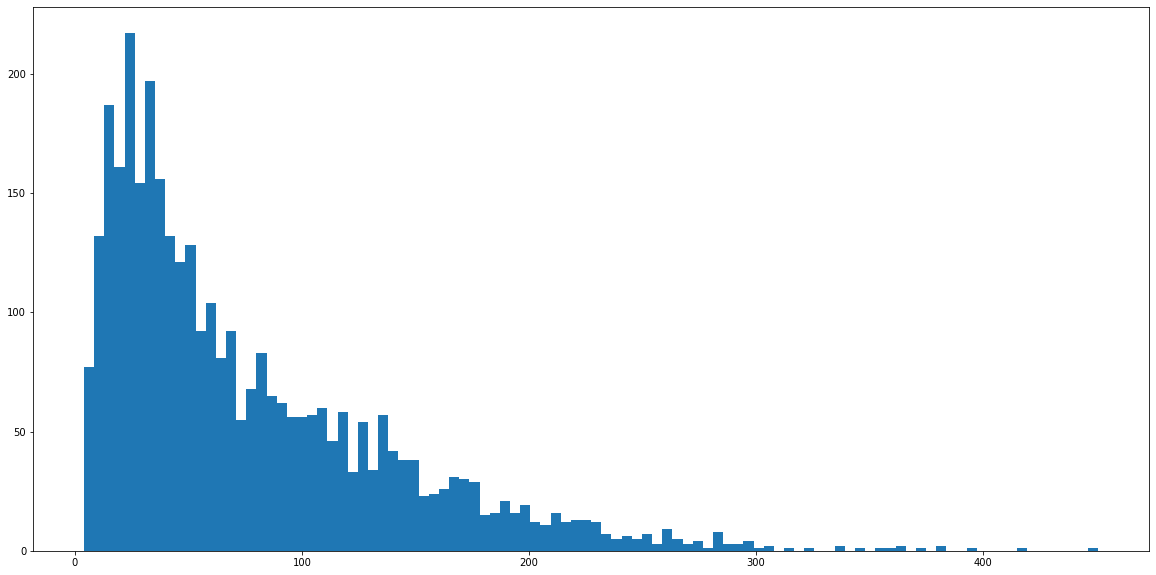

In [ ]:
# View distribution of sentence lengths

_ = plt.hist([len(x) for x in novel_sentences_ls], bins=100)

# **Clean and Slice Strings**

In [ ]:
def clean_str(dirty_str):
  '''
  INPUT: a raw string
  OUTPUT: a clean string
  '''

  contraction_expanded_str = contractions.fix(dirty_str)

  clean_str = clean(contraction_expanded_str,
      fix_unicode=True,               # fix various unicode errors
      to_ascii=True,                  # transliterate to closest ASCII representation
      lower=True,                     # lowercase text
      no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
      no_urls=False,                  # replace all URLs with a special token
      no_emails=False,                # replace all email addresses with a special token
      no_phone_numbers=False,         # replace all phone numbers with a special token
      no_numbers=False,               # replace all numbers with a special token
      no_digits=False,                # replace all digits with a special token
      no_currency_symbols=False,      # replace all currency symbols with a special token
      no_punct=False,                 # remove punctuations
      # replace_with_punct="",          # instead of removing punctuations you may replace them
      # replace_with_url="<URL>",
      # replace_with_email="<EMAIL>",
      # replace_with_phone_number="<PHONE>",
      # replace_with_number="<NUMBER>",
      # replace_with_digit="0",
      # replace_with_currency_symbol="<CUR>",
      lang="en"                       # set to 'de' for German special handling
  )

  # Replace all new lines/returns with single whitespace
  clean_str = ' '.join(clean_str.split())
  # clean_str = clean_str.replace('\n\r', ' ')
  # clean_str = clean_str.replace('\n', ' ')
  # clean_str = clean_str.replace('\r', ' ')
  # clean_str = ' '.join(clean_str.split())

  # Strip unpaired leading/trailing quotes
  if (clean_str.count('"') % 2 == 1):
    clean_str = clean_str.strip('"')
  if (clean_str.count("'") % 2 == 1):
    clean_str = clean_str.strip("'")

  return clean_str 

# Test

clean_str("This \n\n\n is a very dirty DIRTY StrInG!!")
clean_str('"up!')
clean_str('"Watch out!" he said.')

'this is a very dirty dirty string!!'

'up!'

'"watch out!" he said.'

In [ ]:
# Verify

# verify_novel(novel_clean_str, index_ends=500)

In [ ]:
# Create sentiment_df to hold text sentences and corresponding sentiment values

sentiment_df = pd.DataFrame({'text_raw': novel_sentences_ls})
sentiment_df['text_raw'] = sentiment_df['text_raw'].astype('string')
sentiment_df['text_raw'] = sentiment_df['text_raw'].str.strip()

sentiment_df.head()
sentiment_df.info()

,text_raw
0,In my younger and more vulnerable years my fa...
1,"""Whenever you feel like criticizing any one,"" ..."
2,He didn't say any more but we've always been u...
3,In consequence I'm inclined to reserve all jud...
4,The abnormal mind is quick to detect and attac...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3423 entries, 0 to 3422
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text_raw  3423 non-null   string
dtypes: string(1)
memory usage: 26.9 KB


In [ ]:
# clean the 'text_raw' column and create the 'text_clean' column

# novel_df['text_clean'] = hero.clean(novel_df['text_raw'])
sentiment_df['text_clean'] = sentiment_df['text_raw'].apply(lambda x: clean_str(x))
sentiment_df['text_clean'] = sentiment_df['text_clean'].astype('string')
sentiment_df['text_raw_len'] = sentiment_df['text_raw'].apply(lambda x: len(x))

sentiment_df.head()
sentiment_df.info()

,text_raw,text_clean,text_raw_len
0,In my younger and more vulnerable years my fa...,in my younger and more vulnerable years my fat...,121
1,"""Whenever you feel like criticizing any one,"" ...","""whenever you feel like criticizing any one,"" ...",151
2,He didn't say any more but we've always been u...,he did not say any more but we have always bee...,147
3,In consequence I'm inclined to reserve all jud...,in consequence i am inclined to reserve all ju...,163
4,The abnormal mind is quick to detect and attac...,the abnormal mind is quick to detect and attac...,252


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3423 entries, 0 to 3422
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_raw      3423 non-null   string
 1   text_clean    3423 non-null   string
 2   text_raw_len  3423 non-null   int64 
dtypes: int64(1), string(2)
memory usage: 80.4 KB


In [ ]:
# Drop Sentence if Raw length < 1 (Double check)

# sentiment_df = sentiment_df[sentiment_df['text_raw_len'] > 0]

print(f"\n\nThere are {sentiment_df['text_raw'].isna().sum()} BLANK [text_raw] lines")

print(f"There are {sentiment_df['text_clean'].isna().sum()} BLANK [text_clean] lines")

sentiment_df.shape



There are 0 BLANK [text_raw] lines
There are 0 BLANK [text_clean] lines


(3423, 3)

In [ ]:
sentiment_df.sort_values(by=['text_raw_len']).head(20)

,text_raw,text_clean,text_raw_len
2044,Hot!,hot!,4
2077,"""Mr.",mr.,4
2043,Hot!,hot!,4
2042,Hot!,hot!,4
2558,God!,god!,4
3382,"""Yes.",yes.,5
2671,"New.""",new.,5
3169,"""—Mr.",--mr.,5
205,"""Yes.",yes.,5
3093,"""No.""","""no.""",5


# **Sentiment Analysis**

## **VADER**

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_sa = SentimentIntensityAnalyzer()

In [ ]:
vader_sa.polarity_scores('I love lint')['compound']

0.6369

In [ ]:
sentiment_df['vader'] = sentiment_df['text_clean'].apply(lambda x : vader_sa.polarity_scores(x)['compound'])
sentiment_df.head(10)

,text_raw,text_clean,text_raw_len,vader
0,In my younger and more vulnerable years my fa...,in my younger and more vulnerable years my fat...,121,-0.2944
1,"""Whenever you feel like criticizing any one,"" ...","""whenever you feel like criticizing any one,"" ...",151,-0.2755
2,He didn't say any more but we've always been u...,he did not say any more but we have always bee...,147,0.7684
3,In consequence I'm inclined to reserve all jud...,in consequence i am inclined to reserve all ju...,163,-0.2732
4,The abnormal mind is quick to detect and attac...,the abnormal mind is quick to detect and attac...,252,-0.2960
5,Most of the confidences were unsought—frequent...,most of the confidences were unsought--frequen...,356,-0.3818
6,Reserving judgments is a matter of infinite hope.,reserving judgments is a matter of infinite hope.,49,0.4588
7,I am still a little afraid of missing somethin...,i am still a little afraid of missing somethin...,199,-0.7380
8,"And, after boasting this way of my tolerance, ...","and, after boasting this way of my tolerance, ...",90,0.2960
9,Conduct may be founded on the hard rock or the...,conduct may be founded on the hard rock or the...,119,-0.2481


## **TextBlob**

In [ ]:
from textblob import TextBlob

In [ ]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.polarity)

0.39166666666666666


In [ ]:
sentiment_df['textblob'] = sentiment_df['text_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)
sentiment_df.head(10)

,text_raw,text_clean,text_raw_len,vader,textblob
0,In my younger and more vulnerable years my fa...,in my younger and more vulnerable years my fat...,121,-0.2944,0.000000
1,"""Whenever you feel like criticizing any one,"" ...","""whenever you feel like criticizing any one,"" ...",151,-0.2755,0.000000
2,He didn't say any more but we've always been u...,he did not say any more but we have always bee...,147,0.7684,0.500000
3,In consequence I'm inclined to reserve all jud...,in consequence i am inclined to reserve all ju...,163,-0.2732,0.085000
4,The abnormal mind is quick to detect and attac...,the abnormal mind is quick to detect and attac...,252,-0.2960,0.016667
5,Most of the confidences were unsought—frequent...,most of the confidences were unsought--frequen...,356,-0.3818,0.064286
6,Reserving judgments is a matter of infinite hope.,reserving judgments is a matter of infinite hope.,49,0.4588,0.000000
7,I am still a little afraid of missing somethin...,i am still a little afraid of missing somethin...,199,-0.7380,-0.329167
8,"And, after boasting this way of my tolerance, ...","and, after boasting this way of my tolerance, ...",90,0.2960,0.000000
9,Conduct may be founded on the hard rock or the...,conduct may be founded on the hard rock or the...,119,-0.2481,-0.059127


# **Plot Sentiment**

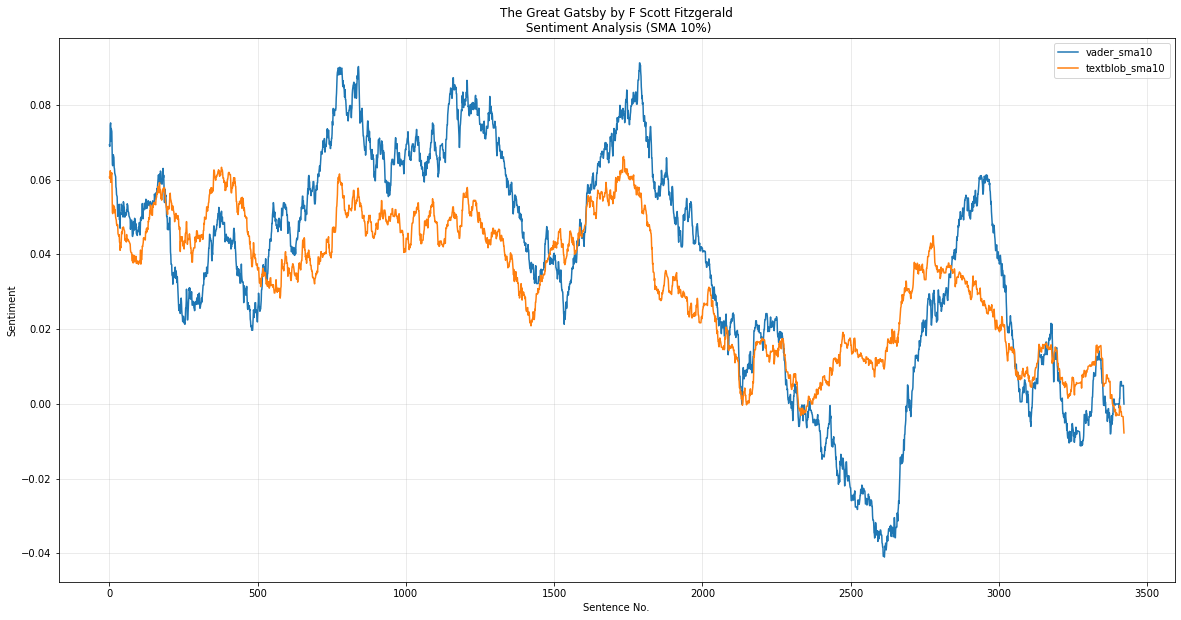

In [ ]:
#@title Enter the Sliding Window width as Percent of Novel length (default 10%, larger=smoother)

window_percent = 10 #@param {type:"slider", min:1, max:20, step:1}

win_per = int(window_percent/100 * sentiment_df.shape[0])

vader_col = f'vader_sma{window_percent}'
sentiment_df[vader_col] = sentiment_df['vader'].rolling(win_per, center=True, min_periods=1).mean()

textblob_col = f'textblob_sma{window_percent}'
sentiment_df[textblob_col] = sentiment_df['textblob'].rolling(win_per, center=True, min_periods=1).mean()
sentiment_df.plot(y=[vader_col, textblob_col])

plt.title(f'{Novel_Title}\n Sentiment Analysis (SMA {window_percent}%)')
plt.ylabel('Sentiment')
plt.xlabel('Sentence No.')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.show();

In [ ]:
sentiment_df.head()

,text_raw,text_clean,text_raw_len,vader,textblob,vader_sma10,textblob_sma10
0,In my younger and more vulnerable years my fa...,in my younger and more vulnerable years my fat...,121,-0.2944,0.000000,0.069327,0.060704
1,"""Whenever you feel like criticizing any one,"" ...","""whenever you feel like criticizing any one,"" ...",151,-0.2755,0.000000,0.068924,0.060351
2,He didn't say any more but we've always been u...,he did not say any more but we have always bee...,147,0.7684,0.500000,0.070105,0.060652
3,In consequence I'm inclined to reserve all jud...,in consequence i am inclined to reserve all ju...,163,-0.2732,0.085000,0.074619,0.062411
4,The abnormal mind is quick to detect and attac...,the abnormal mind is quick to detect and attac...,252,-0.2960,0.016667,0.075209,0.061072


# **Crux Detection**

In [ ]:
#@title Which Lexicon?

Sentiment_Model = "TextBlob" #@param ["VADER", "TextBlob"]

<ipython-input-98-1093e5ba1886>:29: PeakPropertyWarning: some peaks have a width of 0
  peaks3, _ = find_peaks(x, width=width_min)
<ipython-input-98-1093e5ba1886>:37: PeakPropertyWarning: some peaks have a width of 0
  valleys3, _ = find_peaks(x_inv, width=width_min)


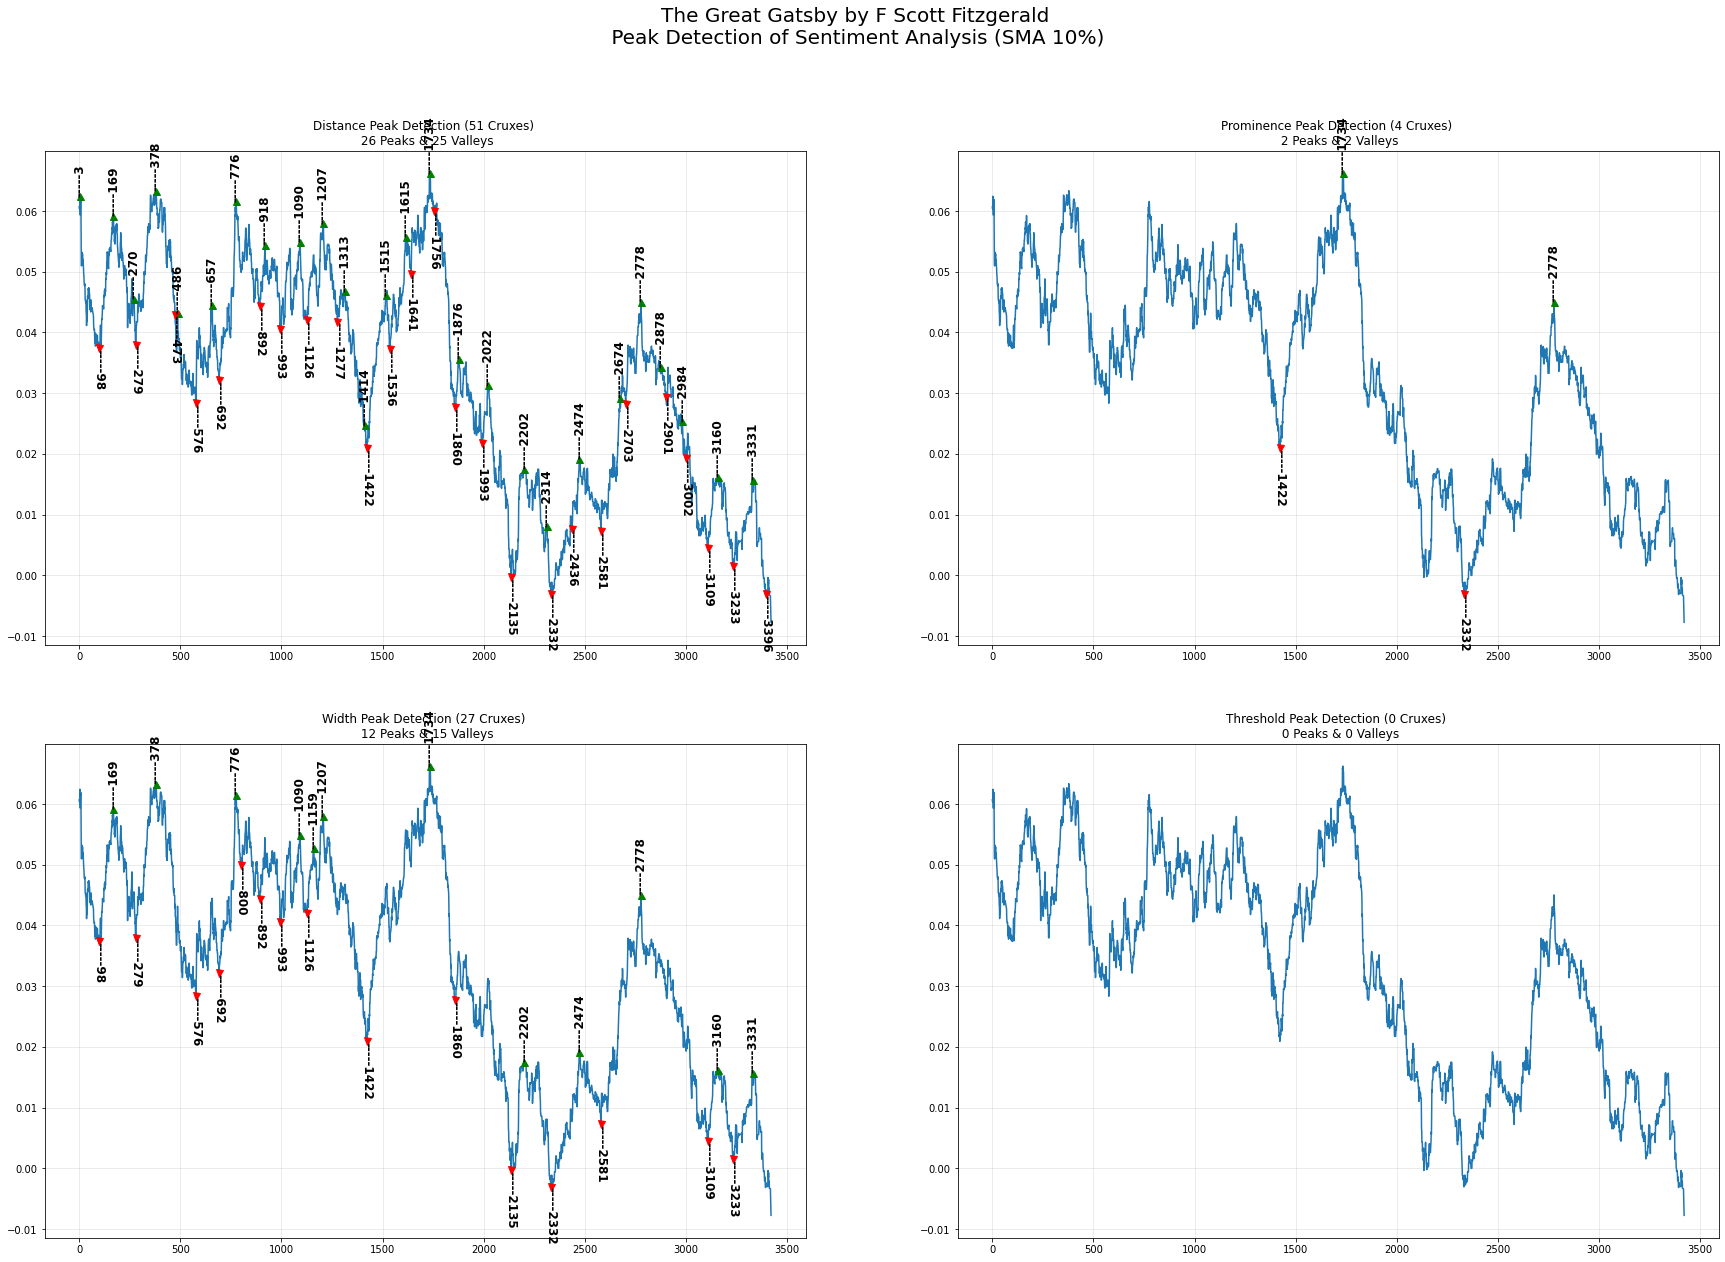

In [ ]:
#@title Tune the main Hyperparameter for each of the 4 Peak Detection Algorithms:

Distance_Min = 100 #@param {type:"slider", min:100, max:1000, step:10}
Prominence_Min = 0.041 #@param {type:"slider", min:0.001, max:0.05, step:0.001}
Width_Min = 25 #@param {type:"slider", min:25, max:500, step:5}
Threshold_Min = 0.009 #@param {type:"slider", min:0.001, max:0.01, step:0.001}

plt.rcParams['figure.figsize'] = [30, 20]

model_name = f'{Sentiment_Model.lower()}_sma{window_percent}'

x = sentiment_df[model_name]

# Peak Algo #1 (by Distance)
distance_min = Distance_Min # 750

# Peak Algo #2 (by Prominence)
prominence_min = Prominence_Min # 0.01

# Peak Algo #3 (by Width)
width_min = Width_Min # 175

# Peak Algo #4 (by Threshold)
threshold_min = Threshold_Min # 0.001


peaks, _ = find_peaks(x, distance=distance_min)
peaks2, _ = find_peaks(x, prominence=prominence_min)      # BEST!
peaks3, _ = find_peaks(x, width=width_min)
peaks4, _ = find_peaks(x, threshold=threshold_min)     # Required vertical distance to its direct neighbouring samples, pretty useless


x_inv = pd.Series([-x for x in sentiment_df[model_name].to_list()])

valleys, _ = find_peaks(x_inv, distance=distance_min)
valleys2, _ = find_peaks(x_inv, prominence=prominence_min)      # BEST!
valleys3, _ = find_peaks(x_inv, width=width_min)
valleys4, _ = find_peaks(x_inv, threshold=threshold_min)     # Required vertical distance to its direct neighbouring samples, pretty useless


_ = plt.subplot(2, 2, 1)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Distance Peak Detection ({len(peaks)+len(valleys)} Cruxes) \n {len(peaks)} Peaks & {len(valleys)} Valleys')
_ = plt.plot(peaks, x[peaks], "^g", markersize=7)
_ = plt.plot(valleys, x[valleys], "vr", markersize=7)
for x_val in peaks:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')

_ = plt.subplot(2, 2, 2)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Prominence Peak Detection ({len(peaks2)+len(valleys2)} Cruxes) \n {len(peaks2)} Peaks & {len(valleys2)} Valleys')
_ = plt.plot(peaks2, x[peaks2], "^g", markersize=7)
_ = plt.plot(valleys2, x[valleys2], "vr", markersize=7)
for x_val in peaks2:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys2:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')


_ = plt.subplot(2, 2, 3)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Width Peak Detection ({len(peaks3)+len(valleys3)} Cruxes) \n {len(peaks3)} Peaks & {len(valleys3)} Valleys')
_ = plt.plot(valleys3, x[valleys3], "vr", markersize=7)
_ = plt.plot(peaks3, x[peaks3], "^g", markersize=7)
for x_val in peaks3:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys3:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')


_ = plt.subplot(2, 2, 4)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Threshold Peak Detection ({len(peaks4)+len(valleys4)} Cruxes) \n {len(peaks4)} Peaks & {len(valleys4)} Valleys')
_ = plt.plot(valleys4, x[valleys4], "vr", markersize=7)
_ = plt.plot(valleys4, x[valleys4], "^g", markersize=7)
for x_val in peaks4:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys4:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')

_ = plt.suptitle(f'{Novel_Title}\n Peak Detection of Sentiment Analysis (SMA {window_percent}%)', fontsize=20)
_ = plt.grid(True, alpha=0.3)

_ = plt.show()

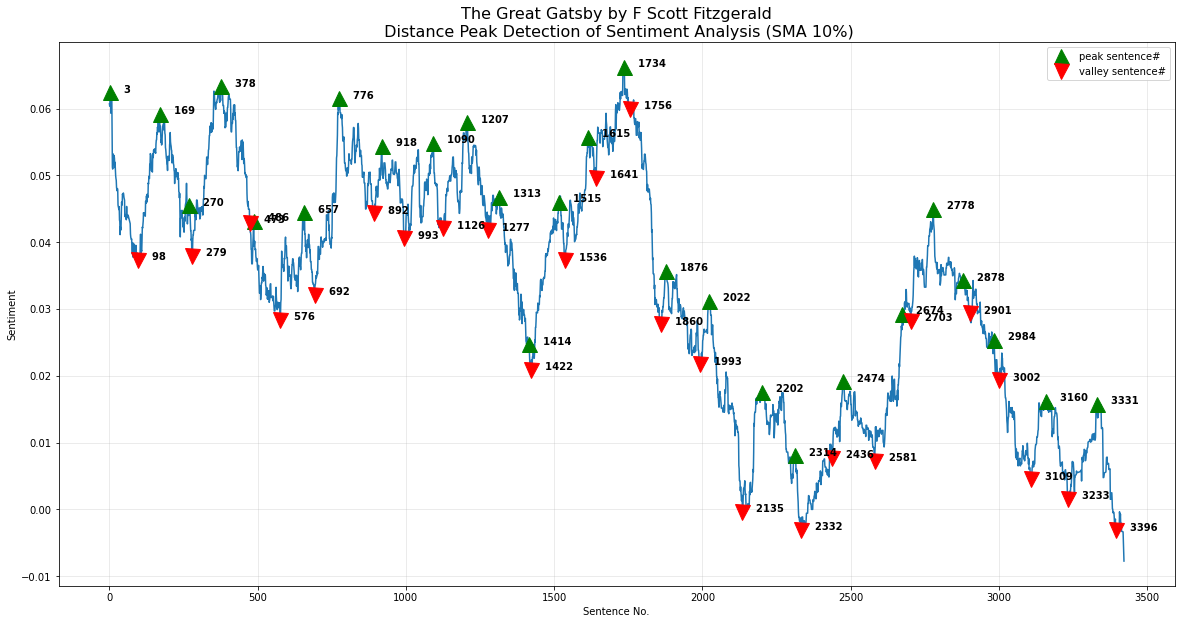



     >>>>> SAVED PLOT TO FILE: [cruxes_plot_The_Great_Gatsby_by_F_Scott_Fitzgerald.png] <<<<<


In [ ]:
#@title Select a Peak Detection Algorithms to View in Detail (usually Distance or Width is best):

plt.rcParams['figure.figsize'] = [20, 10]

Peak_Algorithm = "Distance" #@param ["Distance", "Prominence", "Width", "Threshold"]

if Peak_Algorithm == 'Distance':
  peaks = peaks
  valleys = valleys
elif Peak_Algorithm == 'Prominence':
  peaks = peaks2
  valleys = valleys2  
elif Peak_Algorithm == 'Width':
  peaks = peaks3
  valleys = valleys3
else:
  # Assume Peak_Algorithm == 'Threshold'
  peaks = peaks4
  valleys = valleys4

# model_name = f'{Sentiment_Model.lower()}_sma10'

# x = novel_clean_df[model_name]

# peaks2, _ = find_peaks(x, prominence=peak_prominence)  

# x_inv = pd.Series([-x for x in novel_clean_df[model_name].to_list()])
# valleys2, _ = find_peaks(x_inv, prominence=peak_prominence)     

_ = plt.plot(x)
_ = plt.plot(peaks, x[peaks], "^g", markersize=15, label='peak sentence#')
_ = plt.plot(valleys, x[valleys], "vr", markersize=15, label='valley sentence#')
for x_val in peaks:
  _ = plt.text(x_val, x[x_val], f'    {x_val}', horizontalalignment='left', size='medium', color='black', weight='semibold')
for x_val in valleys:
  _ = plt.text(x_val, x[x_val], f'    {x_val}', horizontalalignment='left', size='medium', color='black', weight='semibold')
_ = plt.title(f'{Novel_Title}\n {Peak_Algorithm} Peak Detection of Sentiment Analysis (SMA {window_percent}%)', fontsize=16)
_ = plt.ylabel('Sentiment')
_ = plt.xlabel('Sentence No.')
_ = plt.legend(loc='best')
_ = plt.grid(True, alpha=0.3)

filename_plot = f"cruxes_plot_{Novel_Title.replace(' ', '_')}.png"
_ = plt.savefig(filename_plot, dpi=300)
_ = plt.show();

print(f'\n\n     >>>>> SAVED PLOT TO FILE: [{filename_plot}] <<<<<')

In [ ]:
# Download Crux Point Plot file 'crux_plot.png' to your laptop

files.download(filename_plot)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Get Context around Crux Points**

In [ ]:
#@title How many Sentences around Crux Point do you want to view for context?

Crux_Sentence_Context_Count = 19 #@param {type:"slider", min:1, max:20, step:1}


In [ ]:
# Print Context around each Sentiment Peak

output_ls = []

halfwin = int(Crux_Sentence_Context_Count/2)
crux_sents_ls = []
nl = '\n'

print('==================================================')
print('============     Peak Crux Points   ==============')
print('==================================================\n\n')

output_ls.append('==================================================')
output_ls.append('============     Peak Crux Points   ==============')
output_ls.append('==================================================\n\n')

# for i, apeak in enumerate(peaks2):
for i, apeak in enumerate(peaks):
  print(f'Processing Peak #{i}...')
  crux_sents_ls = []
  for sent_idx in range(apeak-halfwin,apeak+halfwin+1):
    sent_cur = sentiment_df.iloc[sent_idx].text_raw
    if sent_idx == apeak:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)
  
  # context_ls = sentiment_df.iloc[apeak-halfwin:apeak+halfwin].text_raw
  print(f"Peak #{i} at Sentence #{apeak}:\n\n{nl.join(crux_sents_ls)}\n\n\n")
  output_ls.append(f"Peak #{i} at Sentence #{apeak}:\n\n{nl.join(crux_sents_ls)}\n\n\n")

print('==================================================')
print('===========     Crux Valley Points    ============')
print('==================================================\n\n')

output_ls.append('==================================================')
output_ls.append('===========     Crux Valley Points    ============')
output_ls.append('==================================================\n\n')

# for i, avalley in enumerate(valleys2):
for i, avalley in enumerate(valleys):
  print(f'Processing Valley #{i}')
  crux_sents_ls = []
  for sent_idx in range(avalley-halfwin,avalley+halfwin+1):
    sent_cur = sentiment_df.iloc[sent_idx].text_raw
    if sent_idx == avalley:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)

  # context_ls = novel_df.iloc[avalley-halfwin:avalley+halfwin].text_raw
  print(f"Valley #{i} at Sentence #{avalley}:\n\n{nl.join(crux_sents_ls)}\n\n\n")
  output_ls.append(f"Valley #{i} at Sentence #{avalley}:\n\n{nl.join(crux_sents_ls)}\n\n\n")

filename_cruxes = f"cruxes_context_{Novel_Title.replace(' ', '_')}.txt" 

output_str = ' '.join(output_ls)

with open(filename_cruxes, 'w') as f:
    f.write(output_str)

============     Peak Crux Points   ==============


Processing Peak #0...
Peak #0 at Sentence #3:

Its vanished trees, the trees
that had made way for Gatsby's house, had once pandered in whispers
to the last and greatest of all human dreams; for a transitory
enchanted moment man must have held his breath in the presence of
this continent, compelled into an aesthetic contemplation he
neither understood nor desired, face to face for the last time in
history with something commensurate to his capacity for wonder.
And as I sat there brooding on the old, unknown world, I thought
of Gatsby's wonder when he first picked out the green light at the
end of Daisy's dock.
He had come a long way to this blue lawn and
his dream must have seemed so close that he could hardly fail to
grasp it.
He did not know that it was already behind him, somewhere
back in that vast obscurity beyond the city, where the dark fields
of the republic rolled on under the night.
Gatsby believed in the green light, the o

82619

In [ ]:
# Download Crux Point Report file 'cruxes.txt' to your laptop

files.download(filename_cruxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cat $filename_cruxes

================================================== ============     Peak Crux Points   ============== ==================================================

 Peak #0 at Sentence #3:

Its vanished trees, the trees
that had made way for Gatsby's house, had once pandered in whispers
to the last and greatest of all human dreams; for a transitory
enchanted moment man must have held his breath in the presence of
this continent, compelled into an aesthetic contemplation he
neither understood nor desired, face to face for the last time in
history with something commensurate to his capacity for wonder.
And as I sat there brooding on the old, unknown world, I thought
of Gatsby's wonder when he first picked out the green light at the
end of Daisy's dock.
He had come a long way to this blue lawn and
his dream must have seemed so close that he could hardly fail to
grasp it.
He did not know that it was already behind him, somewhere
back in that vast obscurity beyond the city, where the dark fields
of t

# **END OF NOTEBOOK**